<a href="https://colab.research.google.com/github/DAflamingFOX/MATH-3306/blob/main/TakeHomeLab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bouncing 3D Pyramid
MATH-3306 Take-Home Lab 6 (works with any given point-masses & springs)

In [ ]:
# Imports
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import mpl_toolkits.mplot3d as plt3d

In [ ]:
# Constants

# Simulation bounds
xMin = -5
xMax = 5
yMin = -5
yMax = 5
zMin = -5
zMax = 5

# Time variables
tStart = 0
tDuration = 15
tStop = tStart + tDuration
dt = 0.05
numberOfTimeSteps = int((tStop - tStart)/dt)

# Percentage of gravity to use.
gravity_coef = 1

# Percentage of velocity to keep after hitting wall.
elasticity = 0.6

# Physics Objects
points = [
    Point(x=0.5,   y=0,     z=0.5,   vx=-20,  vy=10,  vz=25,  m=1,  c=0.75),
    Point(x=-0.5,  y=0,     z=0.5,   vx=-20,  vy=10,  vz=25,  m=1,  c=0.75),
    Point(x=0,     y=-0.5,  z=-0.5,  vx=-20,  vy=10,  vz=25,  m=1,  c=0.75),
    Point(x=0,     y=0.5,   z=-0.5,  vx=-20,  vy=10,  vz=25,  m=1,  c=0.75)
]

springs = [
    Spring(points[0], points[1], k=135, l=1),
    Spring(points[0], points[2], k=135, l=1),
    Spring(points[0], points[3], k=135, l=1),
    Spring(points[1], points[2], k=135, l=1),
    Spring(points[1], points[3], k=135, l=1),
    Spring(points[2], points[3], k=135, l=1)
]

In [ ]:
class Point:
    def __init__(self, x, y, z, vx, vy, vz, m, c):
        self.pos = np.array([x, y, z], dtype=float)
        self.vel = np.array([vx, vy, vz], dtype=float)
        self.force = np.array([0.0, 0.0, 0.0], dtype=float) # Initialize force vector
        self.mass = m
        self.c = c

    def reset_force(self):
        """Resets the force vector to zero for the next calculation."""
        self.force = np.array([0.0, 0.0, 0.0], dtype=float)

    def update(self, dt):
        """Updates the position and velocity using the force vector"""
        accel = (self.force / self.mass) - (self.c * self.vel)  + [0, 0, gravity_coef * -9.81]
        self.vel += accel*dt
        self.pos += self.vel*dt

    def prevent_boundary_break(self, xMin, xMax, yMin, yMax, zMin, zMax):
        """Keeps the point within the bounding box"""
        # X check
        if (self.pos[0] < xMin):
            self.pos[0] = xMin + (xMin - self.pos[0])
            self.vel[0] = -self.vel[0] * elasticity
        if (xMax < self.pos[0]):
            self.pos[0] = xMax - (self.pos[0] - xMax)
            self.vel[0] = -self.vel[0] * elasticity
        # Y check
        if (self.pos[1] < yMin):
            self.pos[1] = yMin + (yMin - self.pos[1])
            self.vel[1] = -self.vel[1] * elasticity
        if (yMax < self.pos[1]):
            self.pos[1] = yMax - (self.pos[1] - yMax)
            self.vel[1] = -self.vel[1] * elasticity
        # Z check
        if (self.pos[2] < zMin):
            self.pos[2] = zMin + (zMin - self.pos[2])
            self.vel[2] = -self.vel[2] * elasticity
        if (zMax < self.pos[2]):
            self.pos[2] = zMax - (self.pos[2] - zMax)
            self.vel[2] = -self.vel[2] * elasticity


    def draw(self, ax, radius=0.25):
        """Draws a sphere at the point's position."""
        # x, y, z = self.pos

        # Generate data for a sphere
        u, v = np.mgrid[0:2 * np.pi:20j, 0:np.pi:20j]
        sphere_x = radius * np.cos(u) * np.sin(v)
        sphere_y = radius * np.sin(u) * np.sin(v)
        sphere_z = radius * radius    * np.cos(v)

        # Plot the sphere
        return ax.plot_surface(sphere_x + self.pos[0], sphere_y + self.pos[1], sphere_z + self.pos[2], color="k")

In [ ]:
class Spring:
    def __init__(self, point1, point2, k, l):
        self.point1 = point1
        self.point2 = point2
        self.k = k
        self.l = l

    def get_current_length(self):
        """Calculate the current distance between point1 and point2."""
        x1, y1, z1 = self.point1.pos
        x2, y2, z2 = self.point2.pos
        return math.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)

    def calculate_force(self):
        # Displacement vector
        d = self.point2.pos - self.point1.pos
        # Current spring length
        springLength = self.get_current_length()

        # Don't divide by zero.
        if (springLength == 0):
            return

        # Force vector = k * (length - naturalLength) * d hat
        force = self.k * (springLength - self.l) * (d / springLength)

        # Add force to each point.
        self.point1.force += force
        self.point2.force -= force


    def draw(self, ax):
        """Draws a line between the two points to represent the spring."""
        x1, x2 = [self.point1.pos[0], self.point2.pos[0]]
        y1, y2 = [self.point1.pos[1], self.point2.pos[1]]
        z1, z2 = [self.point1.pos[2], self.point2.pos[2]]

        color = 'g'
        length = self.get_current_length()
        if length < 0.95*self.l:
            color = 'r'
        elif length > 1.05 * self.l:
            color = 'b'


        line = plt3d.art3d.Line3D((x1, x2), (y1, y2), (z1, z2), color=color, linewidth=2.5)
        return ax.add_line(line)

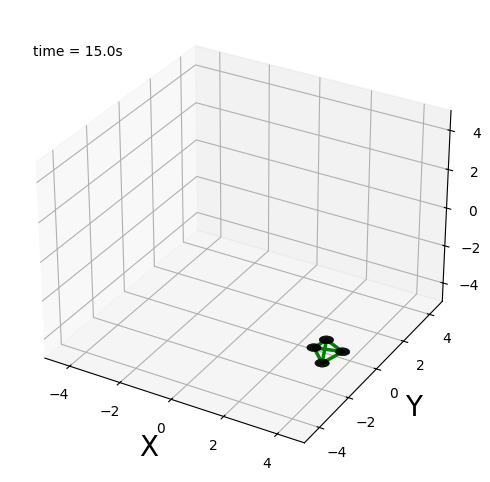

In [ ]:

# Physics Simulation

# Setting up the viewing window
fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(6, 6)
ax = plt.axes(projection='3d')
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)
ax.set_xlim(xMin, xMax)
ax.set_ylim(yMin, yMax)
ax.set_zlim(zMin, zMax)

# Creating the time text to put in the window
time_template = 'time = %.1fs'
time_text = ax.text2D(0.05, 0.9, '', transform=ax.transAxes)

# Draw springs & points
point_artists = [point.draw(ax) for point in points]
spring_artists = [spring.draw(ax) for spring in springs]

# Creating the time text to put in the window
time_template = 'time = %.1fs'
time_text = ax.text2D(0.05, 0.9, '', transform=ax.transAxes)

def animate(i):
    global points, springs

    # Remove points & springs from last iteration.
    for artist in point_artists:
        artist.remove()
    for artist in spring_artists:
        artist.remove()

    # Calculate new forces
    for point in points:
        point.reset_force()

    for spring in springs:
        spring.calculate_force()

    # Display points & springs
    for p in range(len(points)):
        points[p].update(dt)
        points[p].prevent_boundary_break(xMin, xMax, yMin, yMax, zMin, zMax)
        point_artists[p] = (points[p].draw(ax))

    for s in range(len(springs)):
        spring_artists[s] = (springs[s].draw(ax))

    # Update the time
    time_text.set_text(time_template % (i*dt))

    # Group all the artists to return them, idk why this is such a hassel
    artists = point_artists + spring_artists
    artists.append(time_text)

    return artists

anim = animation.FuncAnimation(fig, animate, frames=numberOfTimeSteps, interval=20, blit=True)
HTML(anim.to_html5_video())